# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

### Your Task
- Combine transaction, demographic and offer data 
- Determine which demographic groups respond best to which offer type.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json** 
* age (int) - age of the customer 
    - (numeric) missing value encoded as 118
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income




**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record
    - offer id: (string/hash) not associated with any "transaction"
    - amount: (numeric) money spent in "transaction"
    - reward: (numeric) money gained from "offer completed"




# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from time import time    
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Portfolio
##### Data about the offers (promotions)

In [2]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.id.nunique()

10

We have 10 rows in the portfolio dataframe
- all the 'id' in the 'id' column are unique
- meaning that we have 10 different (unique) offers

In [4]:
# Offers of each type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

- we have 4 unique bogo (buy one get one) offers
- we have 4 unique discount offers
- we have 2 unique informational offers

In [5]:
## Converting id column to offer_id

portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


# 2. Profile Dataset
##### Data about the customers

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


- the 'id' column the is the ID of the customer
- each customer has a unique ID

In [8]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

- we can see here that we have null values for 'gender' and 'income' columns
- this null values need to be REMOVE before we can 'feed' the data set into our machine learning 'model'

In [9]:
profile[profile.age == 118][['gender','age','income']]

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


- mentioned in the 'read me file', the value of 118 in the 'age' column \
means that the value is missing

In [10]:
# No of unique users
profile.id.nunique()

17000

In [11]:
profile.gender.value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

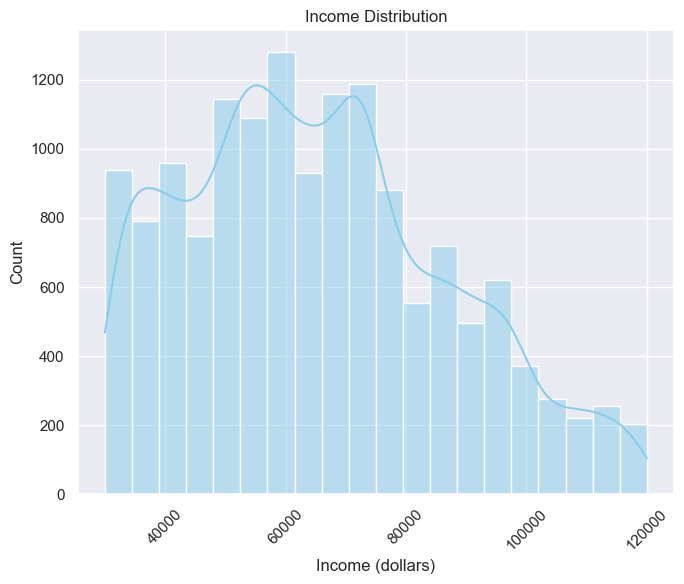

In [12]:
# 'distribution plot' of customer's income

sns.set(style="darkgrid")

plt.figure(figsize=(7, 6))
sns.histplot(profile.income, bins=20, kde=True, color='skyblue')

plt.title('Income Distribution')
plt.xlabel('Income (dollars)')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

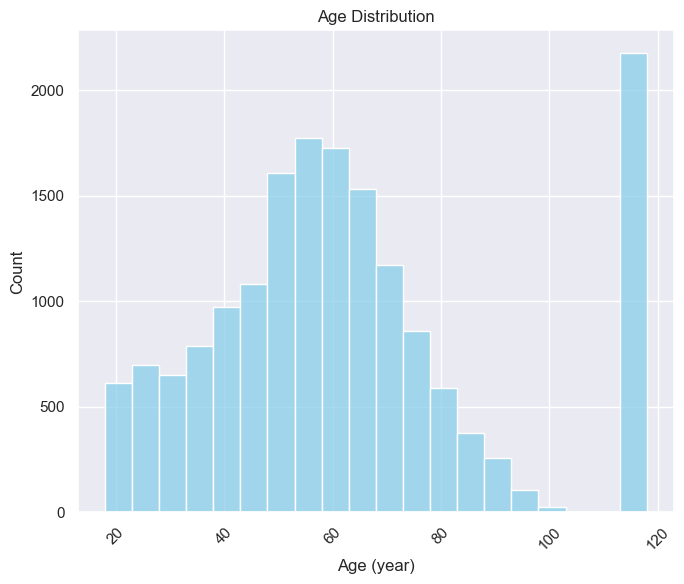

In [13]:
# histogram plot of customers' age

sns.set(style="darkgrid")

plt.figure(figsize=(7, 6))
sns.histplot(profile.age, bins=20, kde=False, color='skyblue')

plt.title('Age Distribution')
plt.xlabel('Age (year)')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


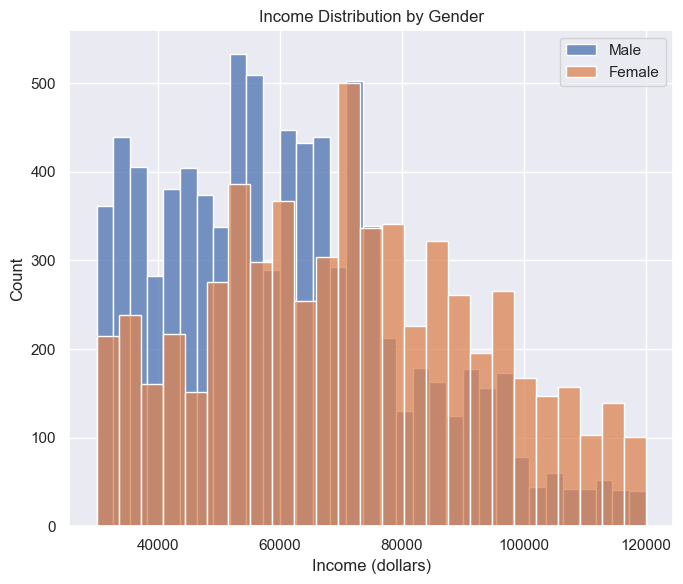

In [14]:
# overlapping 'histogram plot' of customers' income and gender (Male and Female)

sns.set(style="darkgrid")

plt.figure(figsize=(7, 6))
sns.histplot(profile[profile.gender=='M'].income, label='Male')
sns.histplot(profile[profile.gender=='F'].income, label='Female')

plt.title('Income Distribution by Gender')
plt.xlabel('Income (dollars)')
plt.ylabel('Count')

plt.legend()
plt.tight_layout()

plt.show()

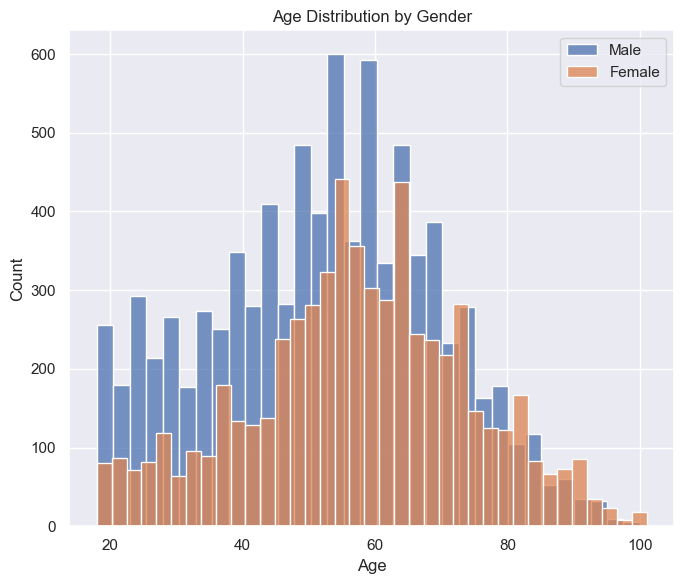

In [15]:
# overlapping histogram plot of customers' age by gender (Male and Female)

sns.set(style="darkgrid")

plt.figure(figsize=(7, 6))
sns.histplot(profile[profile.gender=='M'].age, label='Male')
sns.histplot(profile[profile.gender=='F'].age, label='Female')

plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Count')

plt.legend()
plt.tight_layout()

plt.show()


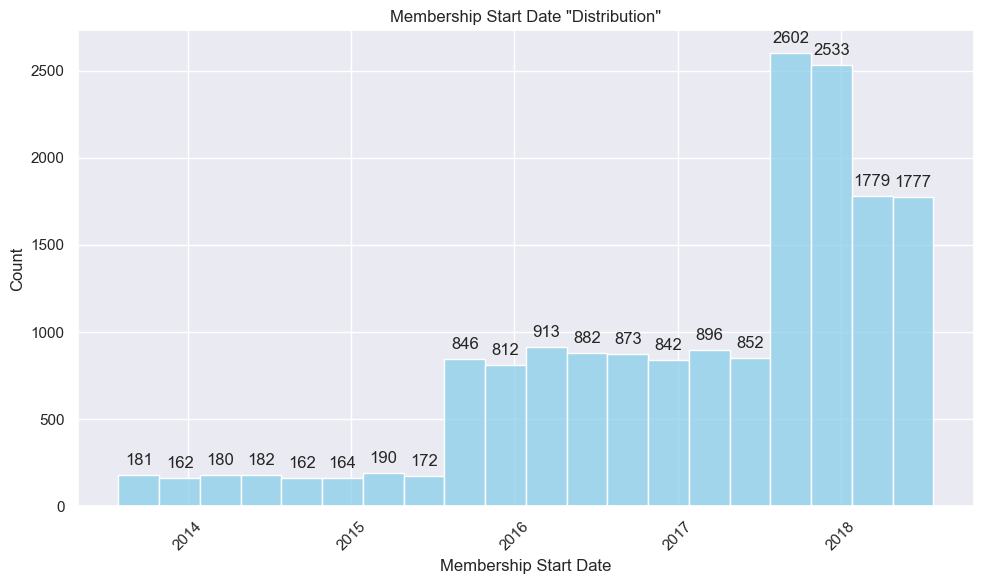

In [16]:
# histogram plot of membership start1 date ( how long customers have been members )

sns.set(style="darkgrid")

temp1 = pd.DataFrame()
temp1['became_member_on_numeric'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

plt.figure(figsize=(10, 6))
ax = sns.histplot(temp1['became_member_on_numeric'], bins=20, kde=False, color='skyblue')

plt.title('Membership Start Date "Distribution"')
plt.xlabel('Membership Start Date')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.tight_layout()

# Display count values on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2. #  calculation allows us to find the x-coordinate of the center of each bar in the histogram plot
    y = height
    
    ax.annotate(f"{height:.0f}", (x, y), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')


plt.show()



# 3. Transcript dataset
##### Data about the transactions (money spent by customers) 

In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [18]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [19]:
# adding all the diffeeent types of 'events' that customer 'created' together
transcript.groupby('event').count()

,person,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


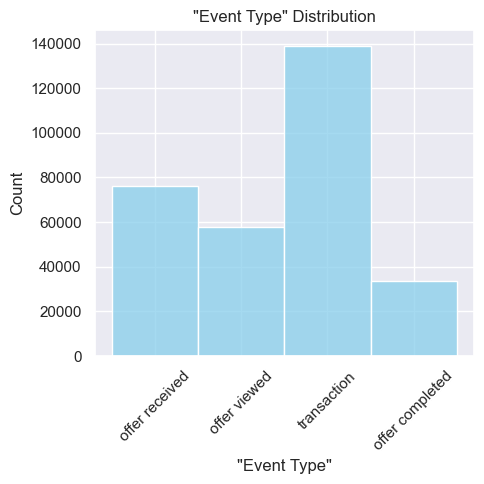

In [20]:
# 'distribution plot' of the above line
sns.set(style="darkgrid")

plt.figure(figsize=(5, 5))
sns.histplot(transcript.event, bins=20, kde=False, color='skyblue')

plt.title('"Event Type" Distribution')
plt.xlabel('"Event Type"')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


So, the general ideal 'flow' is:
- 'offer received' -> 'offer viewed' -> 'transaction' -> 'offer completed'

This mean that custermer 
- received an offer
- viewed it
- made a transaction
- completed the offer


To avoid any confusion about the term 'offer completed', here is a definition from the 'read me file':

```
"Offer completed" is an event type that occurs when a customer completes an offer that they received. This means that the customer has met the requirements of the offer and has received the reward associated with it.

For example, if a customer receives a "buy-one-get-one" (BOGO) offer and they make a qualifying purchase, they will receive a reward equal to the value of the second item they purchased. When the customer receives this reward, an "offer completed" event will be recorded in the transcript.json file.

The purpose of tracking "offer completed" events is to determine which offers are most effective at driving customer behavior and to optimize future offers based on this information.
```

In [21]:
# the 'value column' has a dictionary in each row
# extracting the different values in 'value column'
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [22]:
transcript.columns

Index(['person', 'event', 'value', 'time', 'offer id', 'amount', 'offer_id',
       'reward'],
      dtype='object')

From above code, Added 4 new columns to the transcript dataframe
- 'offer id' column
- 'amount' column
- 'offer_id' column
- 'reward' column


In [23]:
# clean up the duplicates in 'offer id' and 'offer_id' and meger into one column

# if 'offer id' is null and 'offer_id' is not null, then 'id_temp' = 'offer_id'
# else 'id_temp' = 'offer id'
transcript['id_temp'] = np.where( transcript['offer id'].isnull() & transcript['offer_id'].notnull(),
                                   transcript['offer_id'], transcript['offer id'] )

# remove the 2 columns 'offer id' and 'offer_id'
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the column 'id_temp' to 'offer_id'
transcript.rename(columns={'id_temp': 'offer_id'}, inplace=True)

In [24]:
transcript.head()

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [25]:
assert transcript.offer_id.nunique() == 10

We still have 10 unique 'offer_id' in the transcript dataframe\
which MATCHES the number of unique 'id' in the portfolio dataframe

```note: 'offer_id' are refering to the 'promotions'```

In [26]:
assert transcript.person.nunique() == 17000

transcript dataframe has 17000 unique 'person'\
also MATCHES the number of unique 'id' in the profile dataframe

```note: 'person' are refering to the 'customers'```

since the 'informational' promotions does not have any 'offer completed' events,\
*no future analysis* will be done on the 'informational' promotions

we will only focus on:
- 'bogo'
- 'discount' 

# 'transcript' dataframe Data Processing

In [27]:
transcript.head(3)

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5


In [28]:
## merging 'transcript' and 'portfolio' dataframes
transcript = transcript.merge( portfolio, how='left', on='offer_id')


added columns:
- reward_x
- reward_y
- channels
- difficulty
- duration
- offer_type

to the 'transcript' dataframe\
why?\
because 'portfolio' dataframe contains information about the 'promotions'\
and 'transcript' dataframe contains information about the 'transactions'

In [29]:
transcript.head(3)

,person,event,value,time,amount,reward_x,offer_id,reward_y,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, email, mobile]",10.0,7.0,discount


In [30]:
transcript2 = pd.DataFrame(transcript) # make a copy of transcript dataframe

transcript2 = transcript2.drop(columns=['reward_x','reward_y'], axis=1,inplace=False)

expected_columns = ['person', 'event', 'value', 'time', 'amount', 'offer_id', 'channels', 'difficulty', 'duration', 'offer_type']
assert list(transcript2.columns) == expected_columns

# assert test for checking that transcript2 dataframe has the same columns as 'expected_columns'

In [31]:
# sort the events by person and time
# 'time' column is now in ascending order
transcript2 = transcript2.sort_values(['person','time'])

assert transcript2['time'].iloc[0] == 168
assert transcript2['time'].iloc[1] == 192
assert transcript2['time'].iloc[2] == 228

transcript2.head(3)

,person,event,value,time,amount,offer_id,channels,difficulty,duration,offer_type
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN


In [32]:
# expression for selecting rows from the specified columns where 'event' is either 'transaction' or 'offer viewed'.
event_filter1 = transcript2['event'].isin(['transaction', 'offer viewed'])
completed_offer = transcript2.loc[event_filter1, ['time', 'offer_id', 'person', 'event']]

below, when we have this 'flow' of:
- 'offer viewed' -> 'transaction'

we can consider that the customer has 'completed' the offer

In [33]:
completed_offer.head()

,time,offer_id,person,event
77705,192,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,offer viewed
89291,228,NaN,0009655768c64bdeb2e877511632db8f,transaction
139992,372,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,offer viewed
168412,414,NaN,0009655768c64bdeb2e877511632db8f,transaction
187554,456,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,offer viewed


In [34]:
filled_df = completed_offer.groupby(['person']).ffill()
completed_offer.update(filled_df)

 # fill NaN values in the DataFrame or Series.
 # copy the last valid observation (non-NaN) forward to the next NaN 'cell'

In [35]:
assert completed_offer['offer_id'].iloc[1] == '5a8bc65990b245e5a138643cd4eb9837'
assert completed_offer['offer_id'].iloc[3] == '3f207df678b143eea3cee63160fa8bed'

completed_offer.head()
# notice row 89291 and 168412 on column 'offer_id'

,time,offer_id,person,event
77705,192,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,offer viewed
89291,228,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,transaction
139992,372,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,offer viewed
168412,414,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,transaction
187554,456,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,offer viewed


In [36]:
# adding the information from 'completed_offer' to 'transcript2' 
# for each 'person', 'time', and 'event'. 
# If there is no information for a given 'person', 'time', and 'event' in completed_offer, 
# the new columns will have NaN values for that row.

transcript2 = transcript2.merge(completed_offer, how='left', on=['person','time','event'])
transcript2.head()

,person,event,value,time,amount,offer_id_x,channels,difficulty,duration,offer_type,offer_id_y
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


- I still don't undersatnd where did 'offer_id_x' and 'offer_id_y' came from?
- So, drop them below

In [37]:
# for 'offer_id' column, if 'offer_id_x' is null, 
# then copy value from 'offer_id_y'
# else copy value from 'offer_id_x'

transcript2['offer_id'] = np.where(transcript2['offer_id_x'].isnull(),
                                            transcript2['offer_id_y'], 
                                            transcript2['offer_id_x'])

# remove columns 'offer_id_x' and 'offer_id_y'
transcript2.drop(columns=['offer_id_x','offer_id_y'], axis=1, inplace=True)

In [38]:
# taking our 'transcript2' DataFrame and merging it with the 'portfolio' DataFrame.
# using 'offer_id' as the common column to match the data.
# doing a 'left' merge, so we keep everything from 'transcript2'
# and just attach matching data from 'portfolio'. If 'portfolio' doesn't have matching data, 
# it will show as 'NaN' in those spots.

transcript2 = transcript2.merge(portfolio, how = 'left', on='offer_id')

In [39]:
# fill NaN values in the 'duration_x' column with values from 'duration_y' column
transcript2['duration'] = np.where(transcript2['duration_x'].isnull(),
                                            transcript2['duration_y'], 
                                            transcript2['duration_x'])

# drop columns
transcript2.drop( columns=['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],
                         axis=1, inplace=True)

# rename columns
transcript2.rename( columns = {'channels_y':'channels','reward_y':'reward'
                                        ,'difficulty_y':'difficulty','offer_type_y':'offer_type'}
                            ,inplace=True)

In [40]:
transcript2.head()

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,3.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,3.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,3.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,informational,4.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,informational,4.0


'Marking' transactions and 'offers completed' event after 'offers viewed' event

In [41]:
# making a copy of 'transcript2' dataframe
# that only includes rows in the 'event' column that are:
events_to_include = ['offer viewed', 'transaction', 'offer completed']
transactions_after_viewed = transcript2[transcript2['event'].isin(events_to_include)].copy()


# create a column 'pre_offer_id' that contains the 'offer_id' from the previous row
# why?
# to determine if the 'offer' was completed after the customer viewed the 'offer'
transactions_after_viewed['pre_offer_id'] = transactions_after_viewed.groupby(['person', 'offer_id'])['offer_id'].shift()


# create a column 'completed_offer' that contains 1 if the 'pre_offer_id' is the same as 'offer_id'
# and 0 if 'they' are not the same
transactions_after_viewed['completed_offer'] = np.where(
    transactions_after_viewed['pre_offer_id'] == transactions_after_viewed['offer_id']
    ,1
    ,0)

In [42]:

transactions_after_viewed.head(3)

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,3.0,NaN,0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,informational,4.0,NaN,0


In [43]:
# creating a new DataFrame named offer_received from the transcript2 DataFrame. 
# The new DataFrame includes only the rows where the 'event' column in transcript2 is equal to 'offer received'.
offer_received = transcript2[transcript2['event']=='offer received']


In [44]:
# adding the 'pre_offer_id' and 'completed_offer' columns to the 'offer_received' DataFrame
# and prefilled with NaN values.

offer_received.loc[ : , ['pre_offer_id', 'completed_offer']] = np.nan 
# select all rows and columns 'pre_offer_id' and 'completed_offer'

In [45]:
offer_received.head(1)

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,3.0,NaN,NaN


In [46]:
# merging the 'offer_received' and 'transactions_after_viewed' DataFrames
# and sorting the rows by 'person' and 'time' columns.
transcript2 = pd.concat([offer_received, transactions_after_viewed], axis=0).sort_values(['person','time'])

In [47]:
transcript2.head(2)

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,3.0,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,informational,3.0,NaN,0.0


In [48]:
# making 2 new DataFrames from the 'transcript2' DataFrame
# each dataframe contains only rows where 'offer_type' is 'bogo' or 'discount'
bogo_only1 = transcript2[transcript2['offer_type']=='bogo'].copy()
discount_only1 = transcript2[transcript2['offer_type']=='discount'].copy()

In [49]:
bogo_only1.head(2) # bogo offers only
discount_only1.head(2) # discount offers only

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
9,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,discount,10.0,NaN,NaN
11,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,528,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,discount,10.0,NaN,0.0


We define a 'success event' as:
- 'offer viewed' -> 'transaction'\
or 
- 'offer viewed' -> 'offer completed'

'success event' will be 'marked' as 1 on the 'valid_completed' column

For BOGO (buy one get one) and 'discount' promotions, a 'success event' is considered as:
- 'offer viewed' -> 'offer completed'

In [50]:
# Filter 'bogo' DataFrame for completed offers
completed_offers = bogo_only1[ (bogo_only1['completed_offer'] == 1) & (bogo_only1['event'] == 'offer completed') ]

# Group by 'person' and 'offer_id' and count the occurrences
grouped_offers = completed_offers[['person', 'offer_id']].groupby(['person', 'offer_id']).count()

# Reset index of the DataFrame
bogo_completed = grouped_offers.reset_index()

##############################################################################################################
##############################################################################################################

# Filter 'discount' DataFrame for completed offers
completed_discount_offers = discount_only1[(discount_only1['completed_offer'] == 1) & (discount_only1['event'] == 'offer completed')]

# Group by 'person' and 'offer_id' and count the occurrences
grouped_discount_offers = completed_discount_offers[['person', 'offer_id']].groupby(['person', 'offer_id']).count()

# Reset index of the DataFrame
discount_completed = grouped_discount_offers.reset_index()


In [51]:
grouped_discount_offers.head()

Empty DataFrame
Columns: []
Index: [(0011e0d4e6b944f998e987f904e8c1e5, 0b1e1539f2cc45b7b9fa7c272da2e1d7), (0011e0d4e6b944f998e987f904e8c1e5, 2298d6c36e964ae4a3e7e9706d1fb8c2), (0020c2b971eb4e9188eac86d93036a77, fafdcd668e3743c1bb461111dcafc2a4), (0020ccbbb6d84e358d3414a3ff76cffd, 2298d6c36e964ae4a3e7e9706d1fb8c2), (003d66b6608740288d6cc97a6903f4f0, fafdcd668e3743c1bb461111dcafc2a4)]

In [52]:
def detect_non_complete_event(df):

    # Select rows where an offer has led to a transaction or has been completed
    completed_offers = df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ]\
            .groupby(['person','offer_id'])\
            .count()\
            .reset_index()
    

    # Select rows where an offer has been received 
    received_offers_only = df[['person','offer_id']][df['event']=='offer received']\
        .groupby(['person','offer_id'])\
        .count()\
        .reset_index()

    # Merge the two DataFrames on 'person' and 'offer_id'
    output1 = completed_offers.merge( received_offers_only, how='right', on=['person','offer_id'], indicator=True )

    return output1



- If you see 'left_only', it means **non-complete event*** the event was just the offer being received.
- If you see *'right_only'*, it means **complete event** (either a transaction or offer completed). THIS IS WHAT YOU WANT

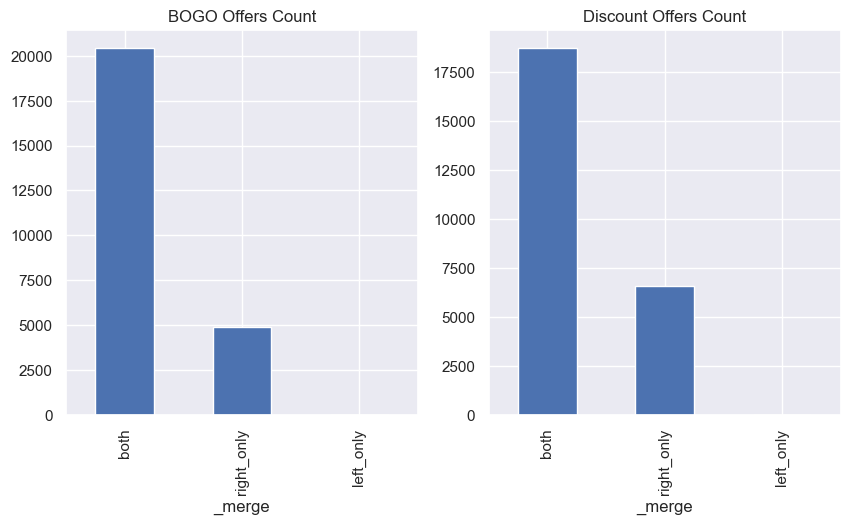

In [53]:
# Counting BOGO offers
bogo_results1 = detect_non_complete_event(bogo_only1)

# Counting Discount offers
discount_results1 = detect_non_complete_event(discount_only1)

# make 2 plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# plot 1
bogo_results1['_merge'].value_counts().plot(kind='bar', title='BOGO Offers Count', ax=ax1)

# plot 2
discount_results1['_merge'].value_counts().plot(kind='bar', title='Discount Offers Count', ax=ax2)

# show plots
plt.show()

Seperating 'complete event' vs 'non-complete event'

In [54]:
# make a new dataframe that contains only rows where the '_merge' column is equal to 'right_only'
rightonly_bogo = bogo_results1[bogo_results1['_merge'] == 'right_only']

# merge the 'rightonly_bogo' DataFrame with the 'transcript2' DataFrame
rightonly_bogo  = rightonly_bogo.merge(transcript2, how='left',on=['person','offer_id'] )

not_eff_bogo = rightonly_bogo[['person','offer_id']][rightonly_bogo['event'] == 'offer viewed']\
    .groupby(['person','offer_id'])\
    .count()\
    .reset_index()

# dropping the '_merge' column
rightonly_bogo.drop(['_merge'], axis=1, inplace=True)

Seperating out customers with only the 'offer received' event for 'discount' promotions

In [55]:
# subtract the customers who received the offer without finishing the transaction
rightonly_discount = discount_results1[discount_results1['_merge']=='right_only']
rightonly_discount = rightonly_discount.merge(transcript2, how='left',on=['person','offer_id'])

# subset users who only viewed the offer and people who viewed the offer but didn't make transaction
not_eff_discount = rightonly_discount[['person','offer_id']][rightonly_discount['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
rightonly_discount.drop(['_merge'], axis=1, inplace=True)



below we seperate customer that has 'complete' offers but did NOT have an\
'offer view' event before the 'complete'

In [56]:
##############################################################################################################
# couting the number of customers who made a 'transaction' without viewing the offer
# 'effect offer type 2'
# for 'bogo' offers

# Filter the DataFrame to include only rows where the 'event' is 'offer completed' and 'completed_offer' is not 1
bogo_completed_filter = (bogo_only1['event'] == 'offer completed') & (bogo_only1['completed_offer'] != 1)

# Apply the filter to select only relevant 'person' and 'offer_id' pairs
bogo_filtered = bogo_only1[bogo_completed_filter][['person', 'offer_id']]

# Group by 'person' and 'offer_id' and count the number of occurrences, then reset the index
bogoEffv2 = bogo_filtered.groupby(['person', 'offer_id']).count().reset_index()
# 'effect offer type 2' for 'bogo' where customer buy without viewing the offer


##############################################################################################################
# couting the number of customers who made a 'transaction' without viewing the offer
# 'effect offer type 2'
# for 'discount' offers

# Filter the DataFrame to select only rows where 'event' is 'offer completed' and 'completed_offer' is not 1
discount_completed_filter = (discount_only1['event'] == 'offer completed') & (discount_only1['completed_offer'] != 1)

# Apply the filter to the DataFrame to select only 'person' and 'offer_id' columns
discount_filtered = discount_only1[discount_completed_filter][['person', 'offer_id']]

# Group by 'person' and 'offer_id', count the occurrences, and reset the index
discountEffv2 = discount_filtered.groupby(['person', 'offer_id']).count().reset_index()
# 'effect offer type 2' for 'discount' where customer buy without viewing the offer



In [57]:
assert discountEffv2.shape == (4458, 2)
assert discountEffv2['person'].iloc[0] == '0009655768c64bdeb2e877511632db8f'
assert discountEffv2['offer_id'].iloc[0] == '2906b810c7d4411798c6938adc9daaa5'

discountEffv2.head()

,person,offer_id
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4
2,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7
3,0056df74b63b4298809f0b375a304cf4,0b1e1539f2cc45b7b9fa7c272da2e1d7
4,0056df74b63b4298809f0b375a304cf4,2298d6c36e964ae4a3e7e9706d1fb8c2


- 'target variable' *effective_offer=1*
- people who 'completed' offers with or without 'viewing an offer' first

- 'target variable' *effective_offer=0* 
- people who DID NOT 'completed' any offers 

In [58]:
# function for combining 2 'dataframes' and 'effect_offer' column
def combine_add_eff_col(asdf1,asdf2):

    # add column 'effective_offer' to both datasets
    asdf1['effective_offer'] = 1 # good 
    asdf2['effective_offer'] = 0 # bad

    # combine both datasets
    offers=pd.concat([asdf1,asdf2], sort=False)
    
    return offers

In [59]:
offers_bogo = combine_add_eff_col(bogo_completed, not_eff_bogo)
offers_discount = combine_add_eff_col(discount_completed, not_eff_discount)

In [60]:
offers_bogo

,person,offer_id,effective_offer
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1
...,...,...,...
2887,ffda4545e7084ff6aaf01304fb1c1fa6,f19421c1d4aa40978ebb69ca19b0e20d,0
2888,ffed75d3abc64b488982f50ed12878b5,4d5c57ea9a6940dd891ad53e9dbe8da0,0
2889,ffed75d3abc64b488982f50ed12878b5,ae264e3637204a6fb9bb56bc8210ddfd,0
2890,fff7576017104bcc8677a8d63322b5e1,ae264e3637204a6fb9bb56bc8210ddfd,0


In [61]:
assert offers_discount['person'].iloc[0] == '0011e0d4e6b944f998e987f904e8c1e5'
# 0011e0d4e6b944f998e987f904e8c1e5

Done with 'combining and processing data'

# Engineering the 'features' for machine learning 'model'

we are converting the 'become_member_on' column to a 'length of time' format

In [62]:
# rename the 'id' column to 'person'
profile.rename(columns={'id':'person'},inplace=True)

In [63]:
# function for converting the 'became_member_on' column 
# to datetime and calculating the number of days since the customer became a member
def member_since(df):


    df=df.merge(profile,how='left',on='person')
    
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    
    ### we are using 2018 because it is the LASTEST year in the dataset
    reference_date = pd.Timestamp(year=2018, month=12, day=31)  # adjust as necessary

    df['membership_days'] = (reference_date - df['became_member_on']).dt.days

    df = df.drop('became_member_on', axis=1, inplace=False)

    return df

In [64]:
offers_bogo=member_since(offers_bogo)
offers_discount=member_since(offers_discount)

In [65]:
offers_bogo.head()

,person,offer_id,effective_offer,gender,age,income,membership_days
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,O,40,57000.0,356
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,F,59,90000.0,1032
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,F,24,60000.0,780
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,F,24,60000.0,780
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,F,55,74000.0,237


# 'offers_bogo' Data Processing

In [66]:
# create dummy variables (also known as one-hot encoding) 
# from a specified column in a pandas DataFrame.


def onehot1(df, col):
    _ = pd.get_dummies(df[col], prefix=col)

    # Change True/False to 1/0 in the column
    dummies = _.replace({True:1, False:0})

    df = pd.concat([df,  dummies], axis=1)  
    df = df.drop(columns=col ,axis=1, inplace=False)    
    
    return df

In [67]:
# merge with portfolio to get offer details
offers_bogo = offers_bogo.merge(portfolio,how='left',on='offer_id')

In [68]:
# convert the stuff in 'channels' column into 'categorical' (apple, banana) variables
# creating four new columns, 'web', 'email', 'social', and 'mobile', 
# and populating them with binary indicators based on whether or not that channel
# is listed in the channels column for each row.

for index, row in offers_bogo.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in offers_bogo.loc[index, 'channels']:
            offers_bogo.loc[index, channel] = 1
        else:
            offers_bogo.loc[index, channel] = 0

In [69]:
# remove the 'channels' column
offers_bogo = offers_bogo.drop(['channels'], axis=1, inplace=False)

In [70]:
# custom fucntion from above
offers_bogo = onehot1(offers_bogo,'gender')

In [71]:
offers_bogo.head()

,person,offer_id,effective_offer,age,income,membership_days,reward,difficulty,duration,offer_type,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,356,5,5,7,bogo,1.0,1.0,0.0,1.0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,1032,10,10,5,bogo,1.0,1.0,1.0,1.0,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,780,5,5,7,bogo,1.0,1.0,0.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,780,5,5,5,bogo,1.0,1.0,1.0,1.0,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,237,5,5,5,bogo,1.0,1.0,1.0,1.0,1,0,0


done with 'offers_bogo'

## 'offers_discount' Data Processing

In [72]:
def convert_process2(df):
       
    # remove columns that has 'null' values (gender, 'income')
    df.dropna(inplace=True);

    # checking for null values, make sure there are none
    assert df.isnull().sum().sum() == 0
    
    # merge with portfolio to get offer details
    df = df.merge(portfolio, how='left',on='offer_id')

    # convert 'channels' into 'one hot' encoding and add 4 new columns (web, email, social, mobile)
    for index, row in df.iterrows():
        for channel in ['web', 'email', 'social', 'mobile']:
            if channel in df.loc[index, 'channels']:
                df.loc[index, channel] = 1
            else:
                df.loc[index, channel] = 0


    # remove the 'channels' column                
    df = df.drop(['channels'], axis=1, inplace=False)
    
    # convert gender column into 'one hot' encoding
    df = onehot1(df,'gender')

    return df

In [73]:
offers_discount.isnull().sum()

person                0
offer_id              0
effective_offer       0
gender             1193
age                   0
income             1193
membership_days       0
dtype: int64

In [74]:
# prepare data for offer_discounts
offers_discount = convert_process2(offers_discount)

In [75]:
offers_discount.head()

,person,offer_id,effective_offer,age,income,membership_days,reward,difficulty,duration,offer_type,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,356,5,20,10,discount,1.0,1.0,0.0,0.0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,356,3,7,7,discount,1.0,1.0,1.0,1.0,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,1032,2,10,10,discount,1.0,1.0,1.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,780,3,7,7,discount,1.0,1.0,1.0,1.0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,558,2,10,10,discount,1.0,1.0,1.0,1.0,1,0,0


done with offers_discount

# Defining 'Helper Functions' for Buidling Machine Learning 'Model'

In [76]:
def divider1(asdf):
    print(f'{asdf}'*20)

In [77]:
def makeTargetAndFeature1(df, col_drop):

    # Split the data into features and target label
    target = df['effective_offer']
    features = df.drop(columns = col_drop, inplace=False, axis=1)

    return features, target

In [78]:
def split_data1(features, target):
    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

    # fit and transform scaling on training data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) # this is combination of 'fit' and 'transform' function

    # scale test data
    X_test = scaler.transform(X_test) # we dont' run 'fit' on 'test' data because we don't want to 'assume' anything about test data

    return X_train, X_test, y_train, y_test

In [79]:
def train_and_prediction1(model, X_train, y_train, X_test, y_test):        
    
    results = {}
    
    # 'Fit' the learner to the training data and get training time
    start1 = time() 
    model = model.fit(X_train, y_train)
    end1 = time() 
    results['train_time'] = end1-start1
    
    # Get predictions on the test set(X_test)
    start1 = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end1 = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end1-start1
    
    # add 'training' accuracy to results
    results['training_score'] = model.score(X_train,y_train)
    
    # add 'testing' accuracy to results
    results['testing_score'] = model.score(X_test,y_test)

    weightedF1 = f1_score(y_test, predictions_test, average='weighted')
    results['weightedF1'] = weightedF1
     

    print(f"{model.__class__.__name__} trained on {len(y_train)} samples.")
    print(f"MSE_train: {mean_squared_error(y_train, predictions_train):.4f}")
    print(f"MSE_test: {mean_squared_error(y_test, predictions_test):.4f}")

    print(f"Training accuracy: {results['training_score']:.4f}")
    print(f"Test accuracy: {results['testing_score']:.4f}")

    print(classification_report(y_test, predictions_test,digits=4))

    divider1('*=')    
    print(f"Weighted F1 score: {weightedF1:.4f}")
    divider1('*=')

    return results

In [80]:
def run_model1(classify1, classify2, name):

    results = {}

    for clf in [classify1, classify2]:
        clf_name = clf.__class__.__name__ + '_' + name # this line is to add 'prefix' to the name of the 'classifier'
        results[clf_name] = {}
        results[clf_name]= train_and_prediction1(clf, X_train, y_train, X_test, y_test)
        
    return pd.DataFrame(results)

# Justification for Selecting the 'weighted average F1 score,' as the 'metric' for the 'model'

The 'class' refers to the possible 'outcomes' or 'labels' in a 'classification' problem
in this project, we have 2 'classes':

- 0, indicating that the offer (promotion) is 'NOT effective'
- 1, indicating that the offer (promotion) is 'effective'

offers_bogo, checking for "class imbalance"

                    person
effective_offer           
0                21.995741
1                78.004259


offers_discount, checking for "class imbalance"

                    person
effective_offer           
0                13.905817
1                86.094183


Text(0.5, 1.0, 'offers_discount "class"')

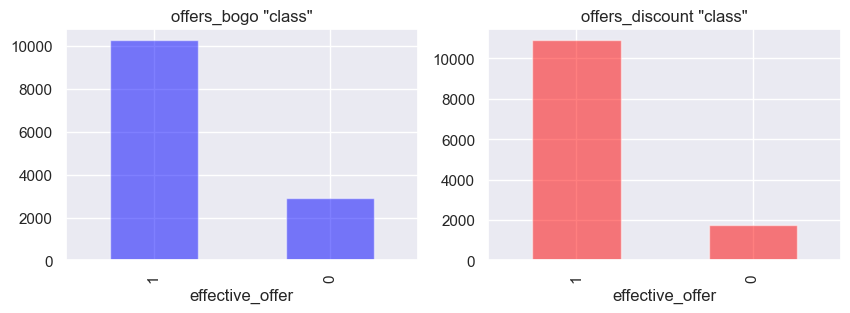

In [81]:
# count the total number of rows with 'effective_offer' == 1
# and count the total number of rows with 'effective_offer' == 0
# then divide both number by the total number of rows in the dataframe
# then multiply by 100 to get the percentage

wat1 = offers_bogo[['person','effective_offer']].groupby('effective_offer').count()
wat2 = len(offers_bogo)
print(f'offers_bogo, checking for "class imbalance"\n')
print(f'{(wat1/wat2)*100}')

print('\n==============================\n')

wat1 = offers_discount[['person','effective_offer']].groupby('effective_offer').count()
wat2 = len(offers_discount)
print(f'offers_discount, checking for "class imbalance"\n')
print((wat1/wat2)*100)


fig, ax = plt.subplots(1,2, figsize=(10,3))
offers_bogo['effective_offer'].value_counts().plot(kind='bar', ax=ax[0], color='blue', alpha=0.5)
ax[0].set_title('offers_bogo "class"')

offers_discount['effective_offer'].value_counts().plot(kind='bar', ax=ax[1], color='red', alpha=0.5)
ax[1].set_title('offers_discount "class"')

as you can see, we have a 'class imbalance' problem for both dataframes:
- offers_bogo
- offers_discount

both have the 'class' of 1 (effective offer) as the 'majority class'

Thus we will use the 'weighted average F1 score,' as the 'metric' for the 'model' because
this 'problem' is considered to be a 'imbalanced classification'. 
Using 'weighted average F1 score' helps to give a more representative score of the model's performance\
across all classes, by giving more importance to the classes with more instances, and If the model doesn't do well\
in predicting a class that has only a small number of instances, the 'weighted average F1-score' won't be dramatically reduce.


# Building Machine Learning 'Model'

Making 2 'models'
- 'model' for BOGO offer
- 'model' for 'discount' offer
- a 'bunchmark model' use to compare with the 2 models above

# Implementation (selecting the type of 'classification algorithm' to use)

This is a (yes/no) 'binary classification' problem where the 'outcome' is either:
- 'effective offer' == 1 
- 'effective offer' == 0

We will use 'Random Forest Classifier' (RFC) as the 'classification algorithm' because:
- Feature importance: Random Forest offers built-in 'feature importance' which will be use to select the 'important feature'.
- Ease of use: Random Forest requires less preprocessing of data. It can handle missing values and 'categorical' data, and not affected by the 'scaling of features'.
- Handling overfitting: By using multiple 'trees', compare to using a single 'decision trees'.

We will also be using 'K nearest neighbors' (KNN) as a 'benchmark model' to compare with the 'RFC' model:
- Performance with imbalanced data: KNN may not perform well on 'imbalanced' data because predictions are based on the nearest neighbors, thus prediction may be biased towards the majority class in case of imbalanced data.

- Sensitive to irrelevant features: KNN treats every 'feature' with the same 'importance' and does not perform well if the dataset has irrelevant 'features'.

 **  identifying 'irrelevant features' is the job of the data scientist **
 
 ** the algorithm does not know which 'features' are 'irrelevant' **

# 'BOGO' machine learning 'model'

we have a NaN value in the 'income' column, total of 947\
DecisionTreeClassifier does not accept missing values encoded as NaN\
So i am filling NaN with 0

In [82]:
# fill the 'income' column with 0
offers_bogo['income'] = offers_bogo['income'].fillna(value=0)

In [83]:
# columns to drop for data preparation
drop_cols_prep = ['person','offer_id','effective_offer','offer_type']
features, target = makeTargetAndFeature1(offers_bogo, drop_cols_prep)

In [84]:
# assert test to check if there are any null values in features
assert features.isnull().sum().sum() == 0, "There are null values in features"

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = split_data1(features, target)

In [86]:
# making 2 machine learning 'models'
# compareModel1 is 'K Nearest Neighbor' model
# bogoModel1 model is 'Randon Forest' model


from sklearn.neighbors import KNeighborsClassifier

# create a KNN model
compareModel1 = KNeighborsClassifier(
    n_neighbors=3,  # choose the number of neighbors
    weights='uniform',  # weight function used in prediction
    algorithm='auto',  # algorithm used to compute the nearest neighbors
    leaf_size=30,  # leaf size passed to BallTree or KDTree
    p=2,  # power parameter for the Minkowski metric
    metric='minkowski',  # the distance metric to use for the tree
    metric_params=None,  # additional keyword arguments for the metric function
    n_jobs=None  # the number of parallel jobs to run for neighbors search
)

bogoModel1 = RandomForestClassifier(
    random_state=2,  # sets the 'seed' for the random number generator, so you can get the same results each time you run the model.
    max_depth=11,  # limits how many splits each tree can have, which helps avoid overly complex trees that overfit to the training data.
    min_samples_split=10,  # a 'node' in the tree will only split if it has at least 10 samples in it, helping to keep the trees simpler and avoid overfitting.
    n_estimators=20,  # sets the number of 'trees in the forest'. More trees mean more varied predictions, which can help to improve accuracy.
    min_samples_leaf=20  # each "leaf" at the end of a tree must have at least 20 samples. It's another way to keep the trees from getting too complex.
)




In [87]:
results = run_model1(compareModel1, bogoModel1, 'bogoModel1')

KNeighborsClassifier trained on 10518 samples.
MSE_train: 0.1255
MSE_test: 0.2300
Training accuracy: 0.8745
Test accuracy: 0.7700
              precision    recall  f1-score   support

           0     0.4749    0.3746    0.4188       582
           1     0.8323    0.8823    0.8566      2048

    accuracy                         0.7700      2630
   macro avg     0.6536    0.6284    0.6377      2630
weighted avg     0.7532    0.7700    0.7597      2630

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
Weighted F1 score: 0.7597
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
RandomForestClassifier trained on 10518 samples.
MSE_train: 0.1737
MSE_test: 0.1840
Training accuracy: 0.8263
Test accuracy: 0.8160
              precision    recall  f1-score   support

           0     0.7311    0.2663    0.3904       582
           1     0.8234    0.9722    0.8916      2048

    accuracy                         0.8160      2630
   macro avg     0.7773    0.6192    0.6410      2630
weighted avg     0.8030    0.81

- The 'weighted average F1 score' of the 'compareModel1' (K Nearest Neighbors) is 0.7597
- The 'weighted average F1 score' of the 'bogoModel1' (Random Forest Classifier) is 0.7807 (last row, at 'f1-score' column)

We can see that RFC performs better than KNN by 0.7807 - 0.7597 = 0.021 (2.1%)

*note 0.7807 and 0.7597 are already in % form*

# 'Discount' machine learning 'model'

- DecisionTreeClassifier does not accept missing values encoded as NaN
- check if 'offers_discount' has any null values

In [88]:
# check if 'offers_discount' has any null values
assert offers_discount.isnull().sum().sum() == 0

In [89]:
# splitting data
drop_cols_prep = ['person','offer_id','effective_offer','offer_type']
features, target = makeTargetAndFeature1(offers_discount, drop_cols_prep)
X_train, X_test, y_train, y_test = split_data1(features, target)

Again, starting with randomly choosen 'hyper-parameters'

In [90]:
discountModel1 = RandomForestClassifier(
    random_state=2,
    max_depth=20,
    min_samples_split=10,
    n_estimators=20,
    min_samples_leaf=10
)


In [91]:
discountModel1Output = run_model1(compareModel1, discountModel1,'discountModel1')

KNeighborsClassifier trained on 10108 samples.
MSE_train: 0.1041
MSE_test: 0.1678
Training accuracy: 0.8959
Test accuracy: 0.8322
              precision    recall  f1-score   support

           0     0.3213    0.2388    0.2740       335
           1     0.8881    0.9229    0.9051      2192

    accuracy                         0.8322      2527
   macro avg     0.6047    0.5809    0.5896      2527
weighted avg     0.8129    0.8322    0.8215      2527

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
Weighted F1 score: 0.8215
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
RandomForestClassifier trained on 10108 samples.
MSE_train: 0.1304
MSE_test: 0.1306
Training accuracy: 0.8696
Test accuracy: 0.8694
              precision    recall  f1-score   support

           0     0.5676    0.0627    0.1129       335
           1     0.8739    0.9927    0.9295      2192

    accuracy                         0.8694      2527
   macro avg     0.7207    0.5277    0.5212      2527
weighted avg     0.8333    0.86

- The 'weighted average F1 score' of the 'compareModel1' (K Nearest Neighbors) is 0.8215
- The 'weighted average F1 score' of the 'discountModel1' (Random Forest Classifier) is 0.8213     (last row, at 'f1-score' column)

We can see that KNN performs better than RFC by 0.8215 - 0.8213 = 0.0002 (0.02%)

In [92]:
results = pd.concat( [results, discountModel1Output], axis=1)
results

,KNeighborsClassifier_bogoModel1,RandomForestClassifier_bogoModel1,KNeighborsClassifier_discountModel1,RandomForestClassifier_discountModel1
train_time,0.038916,0.143338,0.031028,0.142589
pred_time,0.732366,0.031000,0.669815,0.039002
training_score,0.874501,0.826298,0.895924,0.869608
testing_score,0.769962,0.815970,0.832212,0.869410
weightedF1,0.759725,0.780714,0.821472,0.821260


# Refinement (making the 'models' better)

- using 'Grid Search' to find the best 'hyper-parameters' for the 'model'

In [93]:
# function for doing 'grid search' for 'random forest' model
def forest_grid_search(X,y):
    
    # import GridSearchCV
    from sklearn.model_selection import GridSearchCV

    param_grid={
                'max_depth' : [5,10,15],
                'n_estimators': [25,30,40],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10, 15, 20],
                }
    
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    
    return grid_search.best_params_

## Run 'Grid Search' for 'offers_bogo' dataframe

In [94]:
# 'offers_bogo' data processing, making 'features' and 'target'
drop_cols_prep = ['person','offer_id','effective_offer','offer_type']
features, target = makeTargetAndFeature1(offers_bogo, drop_cols_prep)
X_train, X_test, y_train, y_test = split_data1(features, target)

In [95]:
forest_grid_search(X_train, y_train)

{'max_depth': 15,
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 40}

 run my model again with the *new parameters*, keeping the DecisionTree baseline model with the same parameters as comparison.

In [96]:
# 'splitting data' again
features, target = makeTargetAndFeature1(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test = split_data1(features,target)

# making another machine learning 'model'
bogo_model2 = RandomForestClassifier(
    random_state=2,
    
    max_depth=15,
    min_samples_leaf=15,
    min_samples_split=2,
    n_estimators=40,
    
)

In [97]:
_ = run_model1(compareModel1,bogo_model2,'bogo_model2')
results = pd.concat([results, _],axis=1)

KNeighborsClassifier trained on 10518 samples.
MSE_train: 0.1255
MSE_test: 0.2300
Training accuracy: 0.8745
Test accuracy: 0.7700
              precision    recall  f1-score   support

           0     0.4749    0.3746    0.4188       582
           1     0.8323    0.8823    0.8566      2048

    accuracy                         0.7700      2630
   macro avg     0.6536    0.6284    0.6377      2630
weighted avg     0.7532    0.7700    0.7597      2630

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
Weighted F1 score: 0.7597
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
RandomForestClassifier trained on 10518 samples.
MSE_train: 0.1683
MSE_test: 0.1882
Training accuracy: 0.8317
Test accuracy: 0.8118
              precision    recall  f1-score   support

           0     0.6951    0.2663    0.3851       582
           1     0.8226    0.9668    0.8889      2048

    accuracy                         0.8118      2630
   macro avg     0.7588    0.6166    0.6370      2630
weighted avg     0.7944    0.81

# 'Grid Search' for 'offers_discount' Dataset

In [98]:
# splitting data
features, target = makeTargetAndFeature1(offers_discount, drop_cols_prep)
X_train, X_test, y_train, y_test = split_data1(features, target)

forest_grid_search(X_train, y_train)

{'max_depth': 10,
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'n_estimators': 25}

running the 'model' again with the new 'hyper-parameters'

In [99]:
# splitting data
features, target = makeTargetAndFeature1(offers_discount, drop_cols_prep)
X_train, X_test, y_train, y_test = split_data1(features,target)


discountModel2 = RandomForestClassifier(
    random_state = 2, 

    max_depth = 10,
    min_samples_leaf = 20,
    min_samples_split = 2, 
    n_estimators = 25,
)

_ = run_model1(compareModel1, discountModel2,'discountModel2')
results = pd.concat([results, _], axis=1)

KNeighborsClassifier trained on 10108 samples.
MSE_train: 0.1041
MSE_test: 0.1678
Training accuracy: 0.8959
Test accuracy: 0.8322
              precision    recall  f1-score   support

           0     0.3213    0.2388    0.2740       335
           1     0.8881    0.9229    0.9051      2192

    accuracy                         0.8322      2527
   macro avg     0.6047    0.5809    0.5896      2527
weighted avg     0.8129    0.8322    0.8215      2527

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
Weighted F1 score: 0.8215
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
RandomForestClassifier trained on 10108 samples.
MSE_train: 0.1399
MSE_test: 0.1314
Training accuracy: 0.8601
Test accuracy: 0.8686
              precision    recall  f1-score   support

           0     1.0000    0.0090    0.0178       335
           1     0.8685    1.0000    0.9296      2192

    accuracy                         0.8686      2527
   macro avg     0.9342    0.5045    0.4737      2527
weighted avg     0.8859    0.86

In [100]:
# selecting columns to display 'RandomForestClassifier_discountModel1' and 'RandomForestClassifier_discountModel2'
results[ ['RandomForestClassifier_discountModel1','RandomForestClassifier_discountModel2'] ]

,RandomForestClassifier_discountModel1,RandomForestClassifier_discountModel2
train_time,0.142589,0.162335
pred_time,0.039002,0.034373
training_score,0.869608,0.860111
testing_score,0.869410,0.868619
weightedF1,0.821260,0.808719


In [101]:
results[ ['KNeighborsClassifier_discountModel1','KNeighborsClassifier_discountModel2'] ]

,KNeighborsClassifier_discountModel1,KNeighborsClassifier_discountModel2
train_time,0.031028,0.033439
pred_time,0.669815,0.692234
training_score,0.895924,0.895924
testing_score,0.832212,0.832212
weightedF1,0.821472,0.821472


# Checking which 'model' is better and which 'features' are important

After 'grid search'

- the best 'model' for 'offers_bogo' is:
-  RandomForestClassifier_discountModel1 
- with 'weighted average F1 score' of 0.821260
-
- the best 'model' for 'offers_discount' is:
- KNeighborsClassifier_discountModel2 
- with 'weighted average F1 score' of 0.821472


In [102]:
results.transpose()

,train_time,pred_time,training_score,testing_score,weightedF1
KNeighborsClassifier_bogoModel1,0.038916,0.732366,0.874501,0.769962,0.759725
RandomForestClassifier_bogoModel1,0.143338,0.031000,0.826298,0.815970,0.780714
KNeighborsClassifier_discountModel1,0.031028,0.669815,0.895924,0.832212,0.821472
RandomForestClassifier_discountModel1,0.142589,0.039002,0.869608,0.869410,0.821260
KNeighborsClassifier_bogo_model2,0.033000,0.790007,0.874501,0.769962,0.759725
RandomForestClassifier_bogo_model2,0.310992,0.063998,0.831717,0.811787,0.777403
KNeighborsClassifier_discountModel2,0.033439,0.692234,0.895924,0.832212,0.821472
RandomForestClassifier_discountModel2,0.162335,0.034373,0.860111,0.868619,0.808719


Comparing the 'models' with high 'weighted average F1 score' and the 'baseline model'

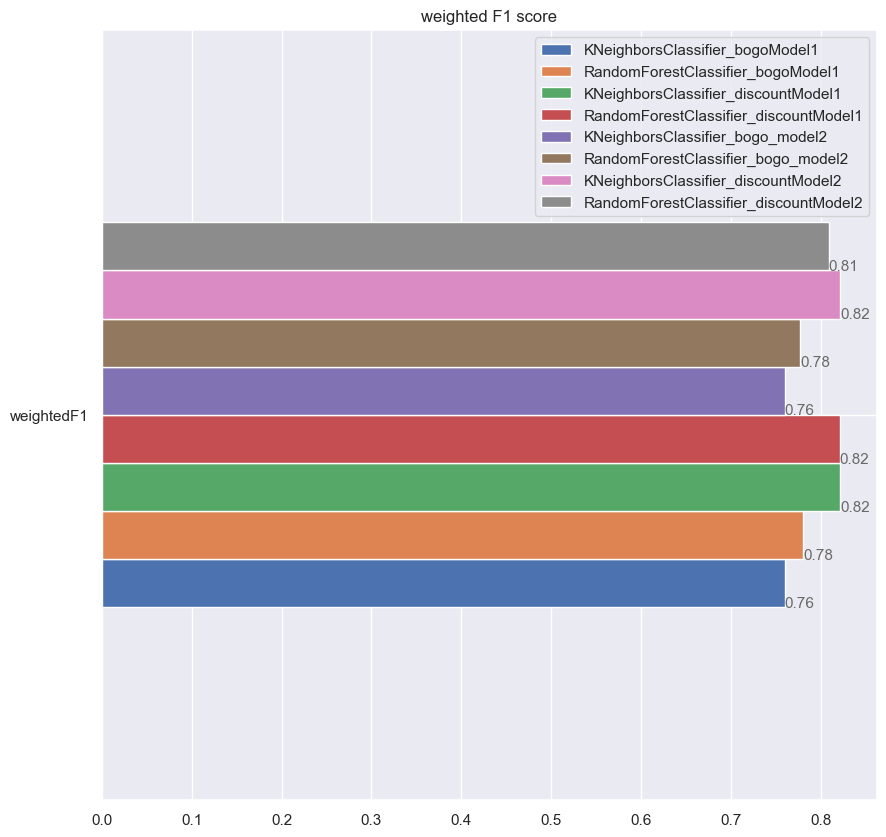

In [103]:
ax = results.loc[['weightedF1']].plot(kind='barh', title='weighted F1 score', figsize=(10, 10))
ax.legend(loc='upper right')

# goes through each bar (patch) in the plot, and places a text at the position of the bar. 
# text is the width of the bar (which corresponds to the value) rounded to 2 decimal places.
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), i.get_y(), \
            str(round((i.get_width()), 2)), fontsize=11, color='dimgrey')

# Why did KNN have a better 'weighted average F1 score' than RFC?

for 'offers_discount' dataset, and it is also an 'imbalanced' dataset

- KNeighborsClassifier_discountModel2	with 0.821472
- RandomForestClassifier_discountModel2	with 0.808719

The improved score is minimal, (0.821472 - 0.808719 ) / 0.808719 * 100 = 1.57%

Reason might be because:
- Random Forest generally 'assumes' that 'features' have some sort of hierarchical structure
- KNN is a non-parametric model, meaning it makes no assumptions about the underlying data distribution. 

Below, we will look at the 'attribute' (feature_importances_) of each 'model' to see which 'features' have the most impact to create an 'effective offer'

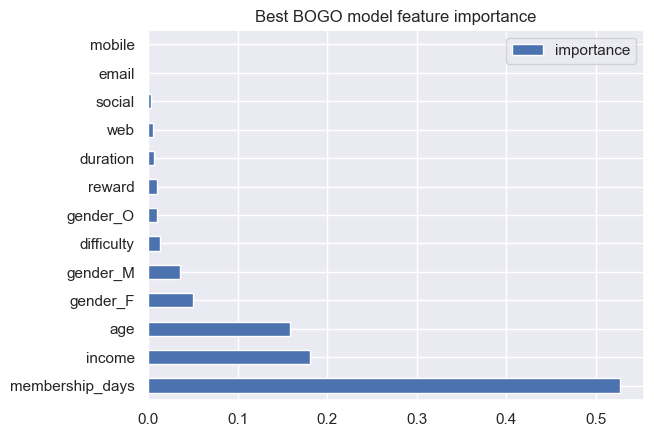

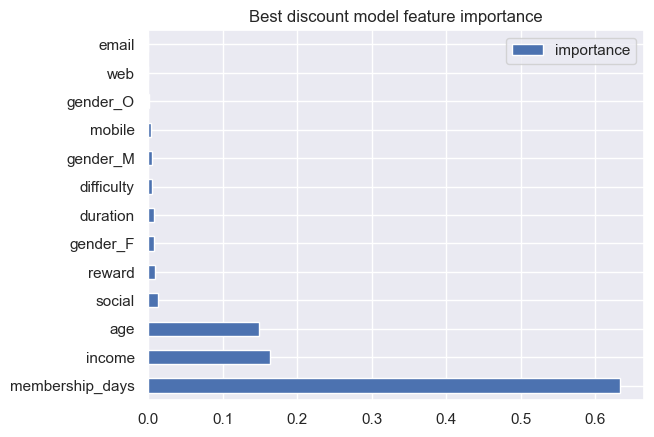

In [104]:
# show 'important features'
# by looking at '.feature_importances_' attribute of 'model'

############################################
# 'bogoModel1' 
############################################

drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features, target = makeTargetAndFeature1(offers_bogo, drop_cols_prep)

feature_importances = pd.DataFrame(bogoModel1.feature_importances_, 
                                   index=features.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot.barh()
plt.title('Best BOGO model feature importance')
plt.show()


############################################
# 'discount' model
############################################

drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features, target = makeTargetAndFeature1(offers_discount, drop_cols_prep)

feature_importances = pd.DataFrame( discountModel1.feature_importances_, 
                                   index = features.columns, 
                                   columns = ['importance']).sort_values('importance', ascending=False)

feature_importances.plot.barh()
plt.title('Best discount model feature importance')
plt.show()




# 'Complication' (checking for 'Data Leakage' with the machine learning 'model')

- *Feature importance*: If any of the 'features' are 'very predictive', it's possible they are causing leakage.

From the 2 plots above, membership_day seems to be 'overwhelmingly'  'important'\
compare to the other 'features'. This could be a sign of 'data leakage'. The keyword here is 'could be'.

# Conclusion

## Possible Improvements for KNN 'Model'

It was unexcepted that KNN would perform better (slightly) than RFC for the 'discount' (or any) dataset, 
but here are some possible improvements that can be made to the 'model' to improve the 'weighted average F1 score':

- Tuning the number of neighbors (K) for KNN 'model': 
    - Run the model with various K values and pick the one which performs best.

- 'Dimensionality Reduction'
    - Big fancy term for reducing the number of 'features' in the dataset using 'Principal Component Analysis' (PCA)

## Possible Improvements for 'Random Forest Model'
- 'Tunning Hyper-parameter' using 'Grid Search'
    - this was done in this project

- 'Feature Importance' 
    - 'Random Forest' provides a tool to measure the importance of each 'feature' in prediction process (done above). 
    - Any 'feature' with small 'imporatnce score' could be removed from the dataset and we can check if the 'weighted average F1 score' will improve.
    - but I will not be doing that.
    

## Reflection

Apply machine learning 'models' to 'classify' customer responses to different type of offers (promotions). We used two different models - K-Nearest Neighbors (KNN) and Random Forest - across various types of offers and datasets.

The analysis began with preprocessing 3 different datasets, which involved cleaning, encoding (one-hot-encoding), and splitting the data into training and testing sets. We then 'trained' our 'models' and evaluated them using the main metrics of 'weighted average F1 score'.

All 3 'models' produced 'weighted average F1' score above 80%. The dataset being imbalanced and somehow KNN has better or same 'weighted average F1 score' with the Random Forest model, which is was suppose to perform better than KNN.

We noted areas for improvement. Hyperparameter tuning, feature scaling for KNN, dimensionality reduction, and analysis of 'feature importance' for 'Random Forest' were some of the things suggested to enhance the models' performance.

